## 카드 소비 데이터

In [4]:
from autogluon.tabular import TabularDataset, TabularPredictor
import dask.dataframe as dd
import vaex
import concurrent.futures
import multiprocessing
import os

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import scipy.stats as spst

## 5개의 시를 병렬로 처리

In [56]:
# data = '../data/five_city_data/merged_gyeonggi_day.csv'
csv_files = [
    # '../data/five_city_data/merged_data_gm.csv',
    # '../data/five_city_data/merged_data_hs.csv',
    #'../data/five_city_data/merged_data_sh.csv',
    #'../data/five_city_data/merged_data_sw.csv',
    '../data/five_city_data/merged_data_yy.csv'
]

In [52]:
def train_model(file_path):
    print(f"Loading data from {file_path}...")
    card_df = dd.read_csv(file_path,encoding='utf-8')
    time_df = card_df.groupby(["ta_ymd", "admi_cty_no", "card_tpbuz_cd"]).agg({"amt": "sum"}).reset_index()
    print(time_df.head())

    time_df2 = time_df.groupby(['ta_ymd',	'card_tpbuz_cd']).agg({"amt": "mean"}).reset_index()

    time_df2 = time_df2.compute()
    time_df2['ta_ymd'] = pd.to_datetime(time_df2['ta_ymd'], format='%Y%m%d')
    
    # 각 card_tpbuz_cd 별로 날짜 수 계산
    counts = time_df2.groupby('card_tpbuz_cd').size().reset_index(name='count')
    valid_card_tpbuz_cd = counts[counts['count'] >= 28]['card_tpbuz_cd']

    # 28일 이상인 card_tpbuz_cd만 필터링
    time_df2 = time_df2[time_df2['card_tpbuz_cd'].isin(valid_card_tpbuz_cd)]
    
    time_df2 = time_df2.sort_values(by=['card_tpbuz_cd', 'ta_ymd'])
    print("Length:", len(time_df2))


    # train/test 데이터 나누기 (2024년 4월 데이터를 테스트 데이터로)
    train_df = time_df2[time_df2['ta_ymd'] < '2024-04-01']
    test_df = time_df2[time_df2['ta_ymd'] >= '2024-04-01']
    
    train_df = train_df.sort_values(by=['card_tpbuz_cd', 'ta_ymd'])
    test_df = test_df.sort_values(by=['card_tpbuz_cd', 'ta_ymd'])
    
    train_df = TimeSeriesDataFrame.from_data_frame(train_df, id_column = "card_tpbuz_cd", timestamp_column="ta_ymd")
    test_df = TimeSeriesDataFrame.from_data_frame(test_df, id_column = "card_tpbuz_cd", timestamp_column="ta_ymd")
    
    train_df.reset_index()
    test_df.reset_index()
    
    print("Setting up TimeSeriesPredictor...")
    predictor = TimeSeriesPredictor(
        label="amt", 
        prediction_length=26, 
        eval_metric="RMSE", 
        freq="D",
        path=os.path.join('models', os.path.basename(file_path).replace('.csv', '')),
        verbosity=3
    )
    
    print(f"Training model for {file_path}...")
    predictor.fit(
        train_data=train_df,
        random_seed = 42,
        time_limit=3600
    )
    
    predictions = predictor.predict(train_df)
    predictions.head()
    
    
    # Plot 4 randomly chosen time series and the respective forecasts
    predictor.plot(test_df, predictions, quantile_levels=[0.1, 0.9], max_history_length=200, max_num_item_ids=4)
    
    leaderboard = predictor.leaderboard(test_df, silent=True)
    
    # mae = predictor.evaluate_predictions(y_true=test_df, y_pred=predictions, eval_metric='mean_absolute_error')
    print(f"Results for {file_path}:")
    print(f"Mean Absolute Error: {mae}")

    return leaderboard
    #return mae

In [ ]:
# 병렬로 모델 학습 실행
if __name__ == '__main__':
    cpu_count = multiprocessing.cpu_count()
    print(f"Starting parallel model training with {cpu_count//2} CPUs...")
    with multiprocessing.Pool(processes=cpu_count//2) as pool:  # CPU 개수를 조절
        results = pool.map(train_model, csv_files)
    
    # 결과 출력
    for i, result in enumerate(results):
        print(f"Results for {csv_files[i]}:")
        print(f"Mean Absolute Error: {result}")
        print("\n")
    print("Completed all model training.")

Starting parallel model training with 6 CPUs...


In [19]:
# 병렬로 모델 학습 실행
if __name__ == '__main__':
    print("Starting parallel model training...")
    with concurrent.futures.ProcessPoolExecutor(max_workers=os.cpu_count()//3) as executor:
        futures = [executor.submit(train_model, file) for file in csv_files]
        for future in concurrent.futures.as_completed(futures):
            try:
                result = future.result()
                print(f"Result: {result}")
            except Exception as e:
                print(f"An error occurred during processing: {e}")
    
    print("Completed all model training.")

Starting parallel model training...
An error occurred during processing: A process in the process pool was terminated abruptly while the future was running or pending.
An error occurred during processing: A process in the process pool was terminated abruptly while the future was running or pending.
An error occurred during processing: A process in the process pool was terminated abruptly while the future was running or pending.
An error occurred during processing: A process in the process pool was terminated abruptly while the future was running or pending.
An error occurred during processing: A process in the process pool was terminated abruptly while the future was running or pending.
Completed all model training.


In [57]:
for data in csv_files:
    train_model(data)
# train_model('../data/five_city_data/merged_data_gm.csv')

Loading data from ../data/five_city_data/merged_data_yy.csv...
     ta_ymd  admi_cty_no card_tpbuz_cd      amt
0  20230101     41171510           D01    80380
1  20230101     41171510           D02   122724
2  20230101     41171510           D03  4470331
3  20230101     41171510           D04  6442173
4  20230101     41171510           D05  1443341


Beginning AutoGluon training... Time limit = 3600s
AutoGluon will save models to 'models\merged_data_yy'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.18
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          0
Memory Avail:       15.28 GB / 31.69 GB (48.2%)
Disk Space Avail:   564.08 GB / 930.86 GB (60.6%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'freq': 'D',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 26,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'amt',
 'time_limit': 3600,
 'verbosity': 3}

train_data with frequency 'None' has been resampled to frequency 'D'.


Length: 38347
Setting up TimeSeriesPredictor...
Training model for ../data/five_city_data/merged_data_yy.csv...


Provided train_data has 37344 rows (NaN fraction=3.7%), 82 time series. Median time series length is 456 (min=427, max=456). 

Provided data contains following columns:
	target: 'amt'

AutoGluon will gauge predictive performance using evaluation metric: 'RMSE'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-13 11:45:00
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. Training for up to 276.9s of the 3599.4s of remaining time.
	-52973843.7570= Validation score (-RMSE)
	0.05    s     = Training runtime
	2.39    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. Training for up to 299.7s of the 3596.9s of remainin

ValueError: Cannot reserve last prediction_length=26 time steps for evaluation in some time series in data. Please make sure that data includes both historic and future data, and thatall time series have length > prediction_length (at least 27)

In [ ]:
test_df = time_df2[time_df2['ta_ymd'] >= '2024-04-01']

In [21]:
data = '../data/five_city_data/merged_data_gm.csv'

In [33]:
# Dask로 5개 주요시 데이터 읽기
card_df = dd.read_csv(data,encoding='utf-8')


In [34]:
card_df.head()

,ta_ymd,cty_rgn_no,admi_cty_no,card_tpbuz_cd,card_tpbuz_nm_1,card_tpbuz_nm_2,hour,sex,age,day,amt,cnt
0,20230101,41210,41210510,D05,소매/유통,선물/완구,3,M,5,7,57576,2
1,20230101,41210,41210510,D11,소매/유통,종합소매점,3,F,7,7,8523,2
2,20230101,41210,41210510,D11,소매/유통,종합소매점,7,F,7,7,8023,2
3,20230101,41210,41210510,F02,생활서비스,미용서비스,3,M,4,7,28532,2
4,20230101,41210,41210510,F02,생활서비스,미용서비스,4,F,7,7,74074,2


In [26]:
# card_df['item_id'] = card_df['card_tpbuz_cd']

# 'ta_ymd' 열을 'timestamp' 형식으로 변환
card_df['timestamp'] = dd.to_datetime(card_df['ta_ymd'], format='%Y%m%d')

# 'year'와 'month' 열 생성
card_df['year'] = card_df['timestamp'].dt.year
card_df['month'] = card_df['timestamp'].dt.month

# item_id, year, month별로 그룹화하여 데이터 포인트 수 계산
grouped = card_df.groupby(['card_tpbuz_cd', 'year', 'month']).size().reset_index()
grouped = grouped.rename(columns={0: 'count'})

# 데이터 포인트 수가 28일 미만인 그룹 필터링
result = grouped[grouped['count'] < 28]

# 결과를 pandas 데이터프레임으로 변환하여 출력
result_pd = result.compute()
result_pd

,card_tpbuz_cd,year,month,count
60,F12,2023,1,3
61,F12,2023,2,10
70,F17,2023,1,24
71,F17,2023,2,24
144,T03,2023,1,10
...,...,...,...,...
1298,T03,2024,4,5
1301,U02,2024,4,27
1302,U03,2024,4,1
1304,Y01,2024,4,18


In [27]:
result_pd['card_tpbuz_cd'].unique()

array(['F12', 'F17', 'T03', 'T04', 'U02', 'U03', 'Y01', 'Y05', 'F04',
       'F15'], dtype=object)

In [28]:
card_df.head()

,ta_ymd,cty_rgn_no,admi_cty_no,card_tpbuz_cd,card_tpbuz_nm_1,card_tpbuz_nm_2,hour,sex,age,day,amt,cnt,timestamp,year,month
0,20230101,41210,41210510,D05,소매/유통,선물/완구,3,M,5,7,57576,2,2023-01-01,2023,1
1,20230101,41210,41210510,D11,소매/유통,종합소매점,3,F,7,7,8523,2,2023-01-01,2023,1
2,20230101,41210,41210510,D11,소매/유통,종합소매점,7,F,7,7,8023,2,2023-01-01,2023,1
3,20230101,41210,41210510,F02,생활서비스,미용서비스,3,M,4,7,28532,2,2023-01-01,2023,1
4,20230101,41210,41210510,F02,생활서비스,미용서비스,4,F,7,7,74074,2,2023-01-01,2023,1


### 코드를 위한 데이터 분리 및 결합

In [35]:
# 해당 일의 해당동의 업종 별 매출 총합
time_df = card_df.groupby(["ta_ymd", "admi_cty_no", "card_tpbuz_cd"]).agg({"amt": "sum"}).reset_index()
time_df.head()

,ta_ymd,admi_cty_no,card_tpbuz_cd,amt
0,20230101,41210510,D05,57576
1,20230101,41210510,D11,16546
2,20230101,41210510,F02,313388
3,20230101,41210510,Q01,69266
4,20230101,41210510,Q15,78222


In [36]:
# time_df의 해당 일의 해당 업종의 평균
time_df2 = time_df.groupby(['ta_ymd',	'card_tpbuz_cd']).agg({"amt": "mean"}).reset_index()

In [37]:
time_df2.head()

,ta_ymd,card_tpbuz_cd,amt
0,20230101,D05,6.332769e+05
1,20230101,D11,9.943861e+07
2,20230101,F02,3.834660e+06
3,20230101,Q01,6.122015e+06
4,20230101,Q15,2.537715e+07


In [38]:
#grouped_df['ta_ymd'] = pd.to_datetime(grouped_df['ta_ymd'], format='%Y%m%d')
# 다음날 매출을 라벨로 추가
#grouped_df['next_day_sales'] = grouped_df.groupby(['admi_cty_no', 'card_tpbuz_cd', 'sex', 'age'])['amt'].shift(-1)
# 데이터 확인
# grouped_df[(grouped_df['ta_ymd'] == '2023-01-01') & 
#                              (grouped_df['admi_cty_no'] == 41210510) & 
#                              (grouped_df['card_tpbuz_cd'] == 'F02')]

In [39]:
# 40104
len(time_df2)

36204

### 날짜 타입 변환

In [40]:
time_df2 = time_df2.compute()

In [41]:
# time_df2['ta_ymd'] = time_df2['ta_ymd'].astype(str)
time_df2['ta_ymd'] = pd.to_datetime(time_df2['ta_ymd'], format='%Y%m%d')

## 모델 학습 -> AutoML 활용

In [42]:
# autogluon 사용
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [43]:
# train, test 분리
# from sklearn.model_selection import train_test_split
# train_df, test_df = train_test_split(time_df2, test_size=0.2, random_state=42)
time_df2 = time_df2.sort_values(by=['card_tpbuz_cd', 'ta_ymd'])

In [44]:
# 각 그룹별로 train/test 데이터 나누기
# train_list = []
# test_list = []

# for card, group in time_df2.groupby('card_tpbuz_cd'):
#     train, test = train_test_split(group, test_size=0.2, shuffle=False)  # 시간 순서를 유지하여 분할
#     train_list.append(train)
#     test_list.append(test)

# # train/test 데이터 합치기
# train_df = pd.concat(train_list)
# test_df = pd.concat(test_list)


# train/test 데이터 나누기 (2024년 4월 데이터를 테스트 데이터로)
train_df = time_df2[time_df2['ta_ymd'] < '2024-04-01']
test_df = time_df2[time_df2['ta_ymd'] >= '2024-04-01']

train_df = train_df.sort_values(by=['card_tpbuz_cd', 'ta_ymd'])
test_df = test_df.sort_values(by=['card_tpbuz_cd', 'ta_ymd'])

In [45]:
test_df

,ta_ymd,card_tpbuz_cd,amt
33996,2024-04-01,D01,9.599712e+06
34072,2024-04-02,D01,7.353035e+06
34145,2024-04-03,D01,6.252892e+06
34220,2024-04-04,D01,5.840443e+06
34300,2024-04-05,D01,6.351334e+06
...,...,...,...
34555,2024-04-08,Y05,5.699000e+04
35371,2024-04-19,Y05,2.274200e+04
35665,2024-04-23,Y05,4.545820e+05
35738,2024-04-24,Y05,1.590100e+06


In [28]:
train_data = TimeSeriesDataFrame.from_data_frame(train_df, id_column = "card_tpbuz_cd", timestamp_column="ta_ymd")

In [29]:
train_data.reset_index()

,item_id,timestamp,amt
0,D01,2023-01-01,5.497930e+07
1,D01,2023-01-02,1.232617e+07
2,D01,2023-01-03,4.692782e+06
3,D01,2023-01-04,9.213441e+06
4,D01,2023-01-05,8.677555e+06
...,...,...,...
33956,Y05,2024-02-28,1.236388e+06
33957,Y05,2024-02-29,1.337800e+04
33958,Y05,2024-03-07,6.616990e+06
33959,Y05,2024-03-22,7.678900e+04


In [30]:
# train_data = TimeSeriesDataFrame.from_data_frame(time_df2, id_column = "card_tpbuz_cd", timestamp_column="ta_ymd")

In [31]:
# train_data = train_data.sort_values(by=['item_id', 'timestamp'])

In [32]:
predictor = TimeSeriesPredictor(label="amt", prediction_length=28, eval_metric="RMSE", freq="D")

In [33]:
predictor.fit(train_data, random_seed = 42,time_limit=3600)

Beginning AutoGluon training... Time limit = 3600s
AutoGluon will save models to 'AutogluonModels\ag-20240712_051319'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.18
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          0
Memory Avail:       17.48 GB / 31.69 GB (55.2%)
Disk Space Avail:   575.35 GB / 930.86 GB (61.8%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'freq': 'D',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 28,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'amt',
 'time_limit': 3600,
 'verbosity': 2}

train_data with frequency 'None' has been resampled to frequency 'D'.
Provided train_data has 37267 rows (NaN fraction=8.9%)

KeyboardInterrupt: 

In [94]:
predictions = predictor.predict(train_data)
predictions.head()

data with frequency 'None' has been resampled to frequency 'D'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean            0.1            0.2  \
item_id timestamp                                                 
D01     2024-04-01  558139.556605  371799.330990  426634.074669   
        2024-04-02  480911.684040  320109.418954  371980.927361   
        2024-04-03  480408.968798  311638.004499  371366.757653   
        2024-04-04  458339.477796  302373.696521  352248.715326   
        2024-04-05  519305.514448  354852.515775  402657.005740   

                              0.3            0.4            0.5  \
item_id timestamp                                                 
D01     2024-04-01  462952.420281  515155.500924  562587.856931   
        2024-04-02  404202.583328  438601.851121  468997.883862   
        2024-04-03  407115.112527  445931.291771  477229.423597   
        2024-04-04  383846.143427  418752.502538  447340.753155   
        2024-04-05  444466.905334  482711.919651  516093.385784   

                              0.6            0.7            0.8            0.9  
item_id timestamp                                                               
D01     2024-04-01  596782.288663  642733.164695  693125.439531  786977.002500  
        2024-04-02  497106.316959  531039.807536  575134.902043  639838.024240  
        2024-04-03  500821.392682  537361.754304  580444.043216  647656.639817  
        2024-04-04  480410.512847  513746.843573  550162.730436  618259.202561  
        2024-04-05  547510.217942  590770.972783  645538.810103  727071.343669

data with frequency 'None' has been resampled to frequency 'D'.


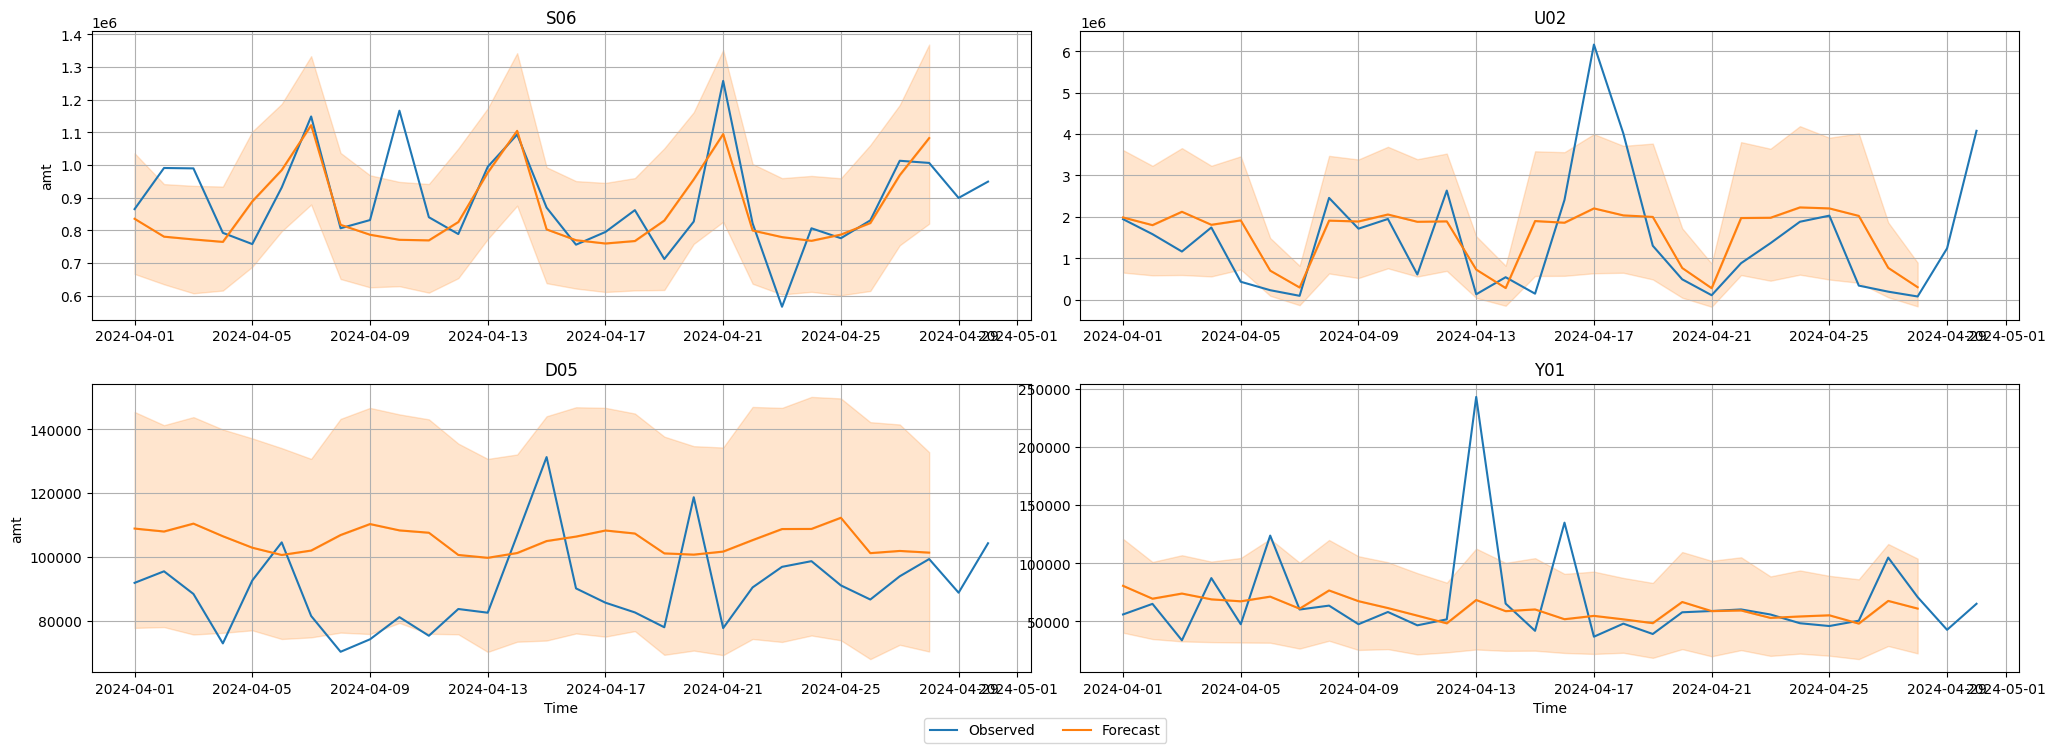

In [95]:
import matplotlib.pyplot as plt

# TimeSeriesDataFrame can also be loaded directly from a file
test_data = TimeSeriesDataFrame.from_data_frame(test_df, id_column = "card_tpbuz_cd", timestamp_column="ta_ymd")

# Plot 4 randomly chosen time series and the respective forecasts
predictor.plot(test_data, predictions, quantile_levels=[0.1, 0.9], max_history_length=200, max_num_item_ids=4)

In [96]:
predictor.leaderboard(test_data)

data with frequency 'None' has been resampled to frequency 'D'.
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,SeasonalNaive,-438952.336676,-772738.835615,0.137611,2.265858,0.032967,1
1,RecursiveTabular,-438952.336676,-509542.789291,0.224465,1.136634,63.334670,2
2,DynamicOptimizedTheta,-438952.336676,-472651.467029,10.823574,26.679834,0.064418,6
3,AutoETS,-438952.336676,-501897.512902,10.115786,20.163729,0.064827,7
4,AutoARIMA,-438952.336676,-540929.730167,6.943752,26.065674,0.063885,8
5,WeightedEnsemble,-442054.721928,-464662.872485,21.285389,49.259050,1.379613,12
6,NPTS,-447786.062568,-501459.324861,0.206228,1.433221,0.045464,5
7,TemporalFusionTransformer,-454086.037632,-483338.183751,0.203465,0.149628,764.011526,9
8,DirectTabular,-457670.457348,-516277.772088,0.177545,0.153619,1.086971,3
9,PatchTST,-459819.900422,-502420.469386,0.298567,0.190507,141.332069,11


In [97]:
# item_id가 'D05'인 데이터만 필터링
# train_df = train_data.reset_index()
# d05_df = train_df[train_df['item_id'] == 'F11']
